<a href="https://colab.research.google.com/github/AtaruOhto/learn_pytorch_advanced/blob/master/1_5_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
# 参照元: https://github.com/YutaroOgawa/pytorch_advanced/blob/master/1_image_classification/1-5_fine_tuning.ipynb
import glob
import os
import random
import urllib

import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import models, transforms



In [3]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

In [4]:
import zipfile

hymenoptera_url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
hymenoptera_zip = os.path.join("hymenoptera_data.zip")

if not os.path.exists(hymenoptera_zip):
    print("アリとハチの画像群をダウンロード")
    urllib.request.urlretrieve(hymenoptera_url, hymenoptera_zip)

    # ZIPファイルを読み込み
    zip = zipfile.ZipFile(hymenoptera_zip)
    zip.extractall("./")  # ZIPを解凍
    zip.close()  # ZIPファイルをクローズ

    # ZIPファイルを消去
    os.remove(hymenoptera_zip)

アリとハチの画像群をダウンロード


In [42]:
class ImageTransform():

  def __init__(self, resize, mean, std):
    self.data_transform = {
        "train": transforms.Compose([
          transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize(mean, std)
        ]),
        "val": transforms.Compose([
          transforms.Resize(resize),
          transforms.CenterCrop(resize),
          transforms.ToTensor(),
          transforms.Normalize(mean, std)
        ])
    }
  
  def __call__(self, img, phase="train"):
    return self.data_transform[phase](img)

In [43]:
def make_datapath_list(phase="train"):
  rootpath = "./hymenoptera_data/"
  target_path = os.path.join(rootpath + phase + "/**/*.jpg")
  print(target_path)

  path_list = []

  # globを利用してサブディレクトリまでファイルパスを取得する
  for path in glob.glob(target_path):
    path_list.append(path)
  return path_list

train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

train_list[:20]

./hymenoptera_data/train/**/*.jpg
./hymenoptera_data/val/**/*.jpg


['./hymenoptera_data/train/ants/196757565_326437f5fe.jpg',
 './hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg',
 './hymenoptera_data/train/ants/24335309_c5ea483bb8.jpg',
 './hymenoptera_data/train/ants/474806473_ca6caab245.jpg',
 './hymenoptera_data/train/ants/150801171_cd86f17ed8.jpg',
 './hymenoptera_data/train/ants/VietnameseAntMimicSpider.jpg',
 './hymenoptera_data/train/ants/2019439677_2db655d361.jpg',
 './hymenoptera_data/train/ants/522163566_fec115ca66.jpg',
 './hymenoptera_data/train/ants/245647475_9523dfd13e.jpg',
 './hymenoptera_data/train/ants/384191229_5779cf591b.jpg',
 './hymenoptera_data/train/ants/450057712_771b3bfc91.jpg',
 './hymenoptera_data/train/ants/662541407_ff8db781e7.jpg',
 './hymenoptera_data/train/ants/535522953_308353a07c.jpg',
 './hymenoptera_data/train/ants/403746349_71384f5b58.jpg',
 './hymenoptera_data/train/ants/army-ants-red-picture.jpg',
 './hymenoptera_data/train/ants/386190770_672743c9a7.jpg',
 './hymenoptera_data/train/ants/822537660_caf4ba55

In [60]:
class HymenopteraDataset(data.Dataset):

  def __init__(self, file_list, transform=None, phase="train"):
    self.file_list = file_list
    self.transform = transform
    self.phase = phase
  
  def __len__(self):
    return len(self.file_list)

  def __getitem__(self, index):
    img_path = self.file_list[index]
    img = Image.open(img_path)

    img_transformed = self.transform(img, self.phase)

    if "/ants/" in img_path:
      label = 0
    elif "/bees/" in img_path:
      label = 1
    
    return img_transformed, label
  
train_dataset = HymenopteraDataset(file_list=train_list, transform=ImageTransform(size, mean, std), phase="train")

val_dataset = HymenopteraDataset(file_list=val_list, transform=ImageTransform(size, mean, std), phase="val")

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


In [61]:
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}
dataloaders_dict



./hymenoptera_data/train/**/*.jpg
./hymenoptera_data/val/**/*.jpg


{'train': <torch.utils.data.dataloader.DataLoader at 0x7fcae41c3860>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7fcae41c31d0>}

In [120]:
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)

net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

net.train()
# 損失関数を設定する
criterion = nn.CrossEntropyLoss()

params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight", "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

for name, param in net.named_parameters():
  if update_param_names_1[0] in name:
    param.requires_grad = True
    params_to_update_1.append(param)
    print("params_to_update_1に格納:", name)

  elif name in update_param_names_2:
    param.requires_grad = True
    params_to_update_2.append(param)
    print("params_to_update_2に格納:", name)

  elif name in update_param_names_3:
    param.requires_grad = True
    params_to_update_3.append(param)
    print("params_to_update_3に格納", name)

  else:
    param.requires_grad = False
    print("勾配計算なし。学習せず", name)

optimizer = optim.SGD([
  {"params": params_to_update_1, "lr": 1e-4},
  {"params": params_to_update_2, "lr": 5e-4},
  {"params": params_to_update_3, "lr": 1e-3}
], momentum=0.9)

params_to_update_1に格納: features.0.weight
params_to_update_1に格納: features.0.bias
params_to_update_1に格納: features.2.weight
params_to_update_1に格納: features.2.bias
params_to_update_1に格納: features.5.weight
params_to_update_1に格納: features.5.bias
params_to_update_1に格納: features.7.weight
params_to_update_1に格納: features.7.bias
params_to_update_1に格納: features.10.weight
params_to_update_1に格納: features.10.bias
params_to_update_1に格納: features.12.weight
params_to_update_1に格納: features.12.bias
params_to_update_1に格納: features.14.weight
params_to_update_1に格納: features.14.bias
params_to_update_1に格納: features.17.weight
params_to_update_1に格納: features.17.bias
params_to_update_1に格納: features.19.weight
params_to_update_1に格納: features.19.bias
params_to_update_1に格納: features.21.weight
params_to_update_1に格納: features.21.bias
params_to_update_1に格納: features.24.weight
params_to_update_1に格納: features.24.bias
params_to_update_1に格納: features.26.weight
params_to_update_1に格納: features.26.bias
params_to_update_1に格納: f

In [121]:
losses = {
    "train": {},
    "val": {}
}

def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"{device}を使います。")

  # ネットワークをGPUに送信
  net.to(device)

  # ネットワークがある程度固定であれば、高速化させる
  torch.backends.cudnn.benchmark = True

  # epochのループ
  for epoch in range(num_epochs):
    print(f"Epoch: {epoch} / {num_epochs}")
    print("========================================")

    # epochごとの訓練と検証のループ
    for phase in ["train", "val"]:
      if phase == "train":
        net.train() # モデルを訓練モードに
      else:
        net.eval() # モデルを検証モードに
      
      epoch_loss = 0.0 # epochの損失和
      epoch_corrects = 0 # epochの正解数

      # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
      if (epoch == 0) and (phase == "train"):
        continue

      # データローダーからミニバッチを取り出すループ
      for inputs, labels in tqdm(dataloaders_dict[phase]):

        # GPUが使えるならGPUにデータを送る
        inputs = inputs.to(device)
        labels = labels.to(device)

        # optimizerを初期化
        optimizer.zero_grad()

        # 順伝播 (forward) 計算
        with torch.set_grad_enabled(phase == "train"):
          outputs = net(inputs)
          loss = criterion(outputs, labels) # 損失計算
          _, preds = torch.max(outputs, 1) # ラベルを予測

          # 訓練時はバックプロパゲーション
          if phase == "train":
            loss.backward()
            optimizer.step()

          epoch_loss += loss.item() * inputs.size(0) # lossの合計を更新
          # 正解数の合計を更新
          epoch_corrects += torch.sum(preds == labels.data)
      epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
      epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
      print(f"モード: {phase}, 誤差: {epoch_loss:.4f}, 正解率: {epoch_acc:.4f}")
      losses[phase][epoch] = epoch_loss
      
# 学習・検証を実行する
num_epochs=5
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)
losses


  0%|          | 0/5 [00:00<?, ?it/s]

cuda:0を使います。
Epoch: 0 / 5


  0%|          | 0/8 [00:00<?, ?it/s]

モード: val, 誤差: 0.6646, 正解率: 0.5817
Epoch: 1 / 5


  0%|          | 0/5 [00:00<?, ?it/s]

モード: train, 誤差: 0.4356, 正解率: 0.7984


  0%|          | 0/8 [00:00<?, ?it/s]

モード: val, 誤差: 0.1682, 正解率: 0.9477
Epoch: 2 / 5


  0%|          | 0/5 [00:00<?, ?it/s]

モード: train, 誤差: 0.1474, 正解率: 0.9424


  0%|          | 0/8 [00:00<?, ?it/s]

モード: val, 誤差: 0.1203, 正解率: 0.9542
Epoch: 3 / 5


  0%|          | 0/5 [00:00<?, ?it/s]

モード: train, 誤差: 0.0795, 正解率: 0.9794


  0%|          | 0/8 [00:00<?, ?it/s]

モード: val, 誤差: 0.1150, 正解率: 0.9542
Epoch: 4 / 5


  0%|          | 0/5 [00:00<?, ?it/s]

モード: train, 誤差: 0.1010, 正解率: 0.9671


100%|██████████| 5/5 [00:01<00:00,  2.64it/s]

モード: val, 誤差: 0.1128, 正解率: 0.9477


{'train': {1: 0.4355782743221448,
  2: 0.14742994814375301,
  3: 0.07947315401378482,
  4: 0.10099742583041328},
 'val': {0: 0.664601054066926,
  1: 0.1682475321238337,
  2: 0.12032910877096108,
  3: 0.11495450663751637,
  4: 0.112845118431484}}

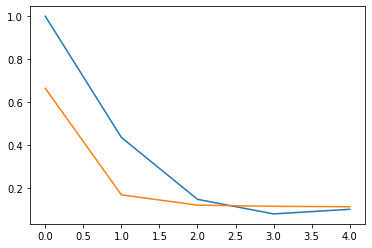

In [122]:
import matplotlib.pyplot as plt
%matplotlib inline 

x = np.arange(num_epochs)
train_losses  = np.insert(np.array(list(losses["train"].values())), 0, 1)
val_losses = np.array(list(losses["val"].values()))

plt.plot(x, train_losses, label="train")
plt.plot(x, val_losses, label="val")


In [123]:
model_path = "./weights_file_tuning.pth"
torch.save(net.state_dict(), model_path)

In [124]:
weights = None

if torch.cuda.is_available():
  # ケース1: GPU上で保存された重みをGPU上でロードする場合
  load_weights = torch.load(model_path)
  weights = net.load_state_dict(load_weights)
else:
  # ケース2: GPU上で保存された重みをCPU上でロードする場合
  load_weights = torch.load(model_path, map_location={"cuda:0": "cpu"})
  weights = net.load_state_dict(load_weights)
  
weights

<All keys matched successfully>